In [9]:
import wave
import glob
import random

# for data, model, training
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models
from scipy import signal

import librosa
import librosa.display

# for visuals and statistics
import matplotlib.pyplot as plt
import seaborn as sns

# Set the seed value for experiment reproducibility.
seed = 42
random.seed(42)
tf.random.set_seed(seed)
np.random.seed(seed)

In [10]:
def get_and_shuffle_filenames(dir_name):
    filenames = glob.glob(str(data_dir) + "/*")
    random.shuffle(filenames)
    return filenames

data_dir = "recordings"
filenames = get_and_shuffle_filenames(data_dir)

print(filenames[:5])

['recordings/2_jackson_13.wav', 'recordings/6_george_34.wav', 'recordings/7_george_5.wav', 'recordings/1_yweweler_21.wav', 'recordings/2_george_42.wav']


In [11]:
# https://www.tensorflow.org/tutorials/audio/simple_audio

def decode_audio(file_path):
    # read file to get buffer                                                                                               
    ifile = wave.open(file_path)
    samples = ifile.getnframes()
    audio = ifile.readframes(samples)

    # convert buffer to float32 using NumPy                                                                                 
    audio_as_np_int16 = np.frombuffer(audio, dtype=np.int16)
    audio_as_np_float32 = audio_as_np_int16.astype(np.float32)
    
    # get largest absolute value
    max_val = np.max(
        np.absolute(
            [np.max(audio_as_np_float32), np.min(audio_as_np_float32)]))
    audio_normalized = audio_as_np_float32 / max_val

    return audio_normalized

def get_label(file_path):
    # label is in the filename
    parts = file_path.split("/")
    label = int(parts[1].split("_")[0])

    return label


In [12]:
# to remove outliers 
X_unfiltered = [(file_path, decode_audio(file_path)) for file_path in filenames]
X_lengths = [audio.shape[0] for _, audio in X_unfiltered]

max_length = int(np.mean(X_lengths) + 2 * np.std(X_lengths))
print(np.mean(X_lengths))
print(np.std(X_lengths))
print(max_length)

3499.4746666666665
1180.9471707171701
5861


In [13]:
def mel_spec(signal):
    mel_spect = librosa.feature.melspectrogram(y=signal, sr=8000, n_fft=248, hop_length=248)
    mel_spect = librosa.power_to_db(mel_spect, ref=np.max)
    return mel_spect

In [23]:
# padding function from
# https://towardsdatascience.com/audio-deep-learning-made-simple-sound-classification-step-by-step-cebc936bbe5

X_full = [] # padded X values
y_full = []

numbers = [0] * 10

for file_path, audio in X_unfiltered:
    x_val = audio
    y_val = get_label(file_path)
    
    signal_length = audio.shape[0]
    if signal_length > max_length:
        numbers[y_val] += 1
    else:
        pad_len = max_length - signal_length
        
        x_val = np.pad(
            x_val, (0, pad_len), 
            'constant', constant_values=(0, 0))
        
        mel_x = mel_spec(x_val)
        
        X_full.append(mel_x)
        y_full.append(y_val)

X_full = np.array(X_full)
y_full = np.array(y_full)

num_samples, sample_w, sample_h = X_full.shape
print(num_samples)
print(sample_w, sample_h)

2911
128 24


In [24]:
# quantities = {"y": list(range(10)), "quantities": numbers}
df = pd.DataFrame.from_dict({"quantities": numbers})
print(df)
print(sum(numbers))

   quantities
0          11
1           8
2           6
3           5
4           3
5           6
6          23
7          11
8           6
9          10
89


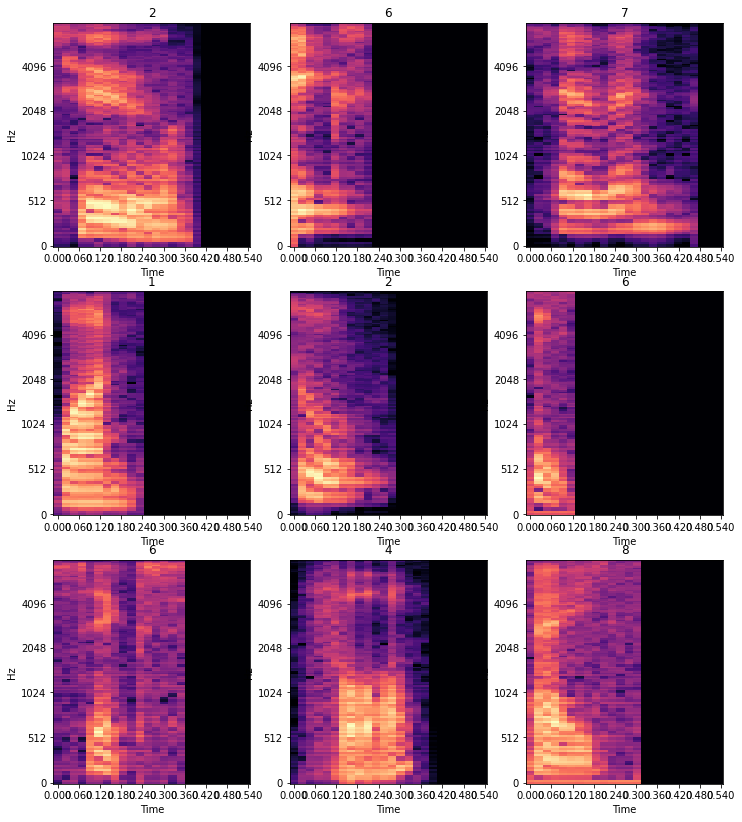

In [25]:
rows = 3
cols = 3
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(12, 14))

for i, (audio, label) in enumerate(list(zip(X_full, y_full))[:n]):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    
    librosa.display.specshow(audio, y_axis='mel', fmax=8000, x_axis='time', ax=axes[r][c]);
#     plt.title('Mel Spectrogram');
#     plt.colorbar(format='%+2.0f dB');
    
#     ax.plot(audio)
#     ax.set_yticks(np.arange(-1,1.5,0.5))
    ax.set_title(label)

plt.show()

In [26]:
tenth = int(num_samples * 0.1)
eightyth = tenth * 8

X_train = X_full[:eightyth]
y_train = y_full[:eightyth]

X_val = X_full[eightyth: eightyth + tenth]
y_val = y_full[eightyth: eightyth + tenth]

X_test = X_full[eightyth + tenth:]
y_test = y_full[eightyth + tenth:]

print('Training set size', len(X_train))
print('Validation set size', len(X_val))
print('Test set size', len(X_test))

Training set size 2328
Validation set size 291
Test set size 292


In [31]:
norm_layer = tf.keras.layers.Normalization()
norm_layer.adapt(data=X_full)

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Input(shape=(sample_w, sample_h, 1)))
model.add(tf.keras.layers.Resizing(32, 32))
model.add(norm_layer)
model.add(tf.keras.layers.Conv2D(32, 3, activation='relu'))
model.add(tf.keras.layers.Conv2D(64, 3, activation='relu'))
model.add(tf.keras.layers.MaxPooling2D())
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation="relu"))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(10, activation="softmax"))

model.build()
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_2 (Resizing)       (None, 32, 32, 1)         0         
                                                                 
 normalization_4 (Normalizat  (None, 32, 32, 24)       49        
 ion)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 30, 30, 32)        6944      
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)       

In [32]:
model.compile(loss="sparse_categorical_crossentropy",
             optimizer="adam",
             metrics=["accuracy"])

In [33]:
history = model.fit(X_train, y_train, epochs=30,
                   validation_data=(X_val, y_val))

Epoch 1/30
73/73 [==============================] - 7s 79ms/step - loss: 4.3327 - accuracy: 0.1585 - val_loss: 2.0448 - val_accuracy: 0.3849
Epoch 2/30
73/73 [==============================] - 6s 78ms/step - loss: 1.6502 - accuracy: 0.3995 - val_loss: 0.6218 - val_accuracy: 0.8454
Epoch 3/30
73/73 [==============================] - 5s 73ms/step - loss: 0.8454 - accuracy: 0.7109 - val_loss: 0.3336 - val_accuracy: 0.9381
Epoch 4/30
73/73 [==============================] - 5s 74ms/step - loss: 0.5342 - accuracy: 0.8140 - val_loss: 0.3120 - val_accuracy: 0.9210
Epoch 5/30
73/73 [==============================] - 5s 73ms/step - loss: 0.4030 - accuracy: 0.8621 - val_loss: 0.1407 - val_accuracy: 0.9622
Epoch 6/30
73/73 [==============================] - 6s 79ms/step - loss: 0.3199 - accuracy: 0.8900 - val_loss: 0.1416 - val_accuracy: 0.9622
Epoch 7/30
73/73 [==============================] - 6s 77ms/step - loss: 0.2853 - accuracy: 0.9089 - val_loss: 0.1051 - val_accuracy: 0.9553
Epoch 8/30
73

In [34]:
model.evaluate(X_test, y_test)

10/10 [==============================] - 0s 12ms/step - loss: 0.0936 - accuracy: 0.9692


[0.09359229356050491, 0.9691780805587769]

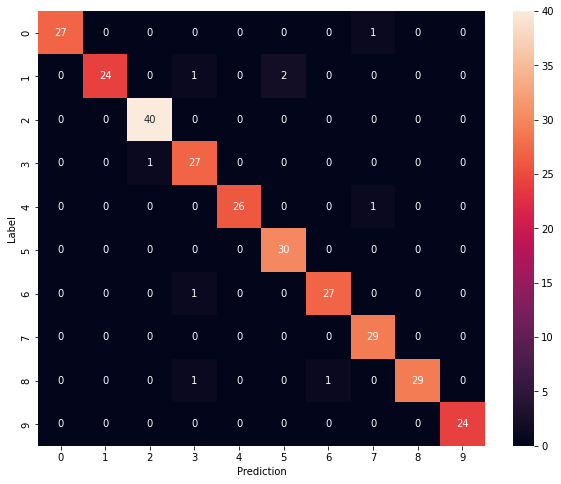

In [35]:
y_pred = np.argmax(model.predict(X_test), axis=1)

all_labels = list(range(10))

confusion_mtx = tf.math.confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=all_labels,
            yticklabels=all_labels,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [36]:
model.save("model_v2.h5")